<a href="https://colab.research.google.com/github/r-isachenko/2023-DGM-MIPT-course/blob/main/seminars/seminar10/seminar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import clear_output

import torch
import torch.distributions as TD
from torch.utils.data import DataLoader
import os, sys

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
# DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

Loading `dgm_utils` and current seminar utils for `colab` users

In [ ]:
REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!mv ./{REPO_NAME}/seminars/seminar10/seminar10_utils.py ./seminar10_utils.py
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Loading `dgm_utils` from local

In [4]:
# importing dgm utils
import os, sys
DGM_UTILS_PATH = '../../homeworks'
sys.path.append(DGM_UTILS_PATH)

In [6]:
# dgm_utils
from dgm_utils import plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_data
from dgm_utils import train_model

# <center>Deep Generative Models</center>
## <center>Seminar 10</center>

<center>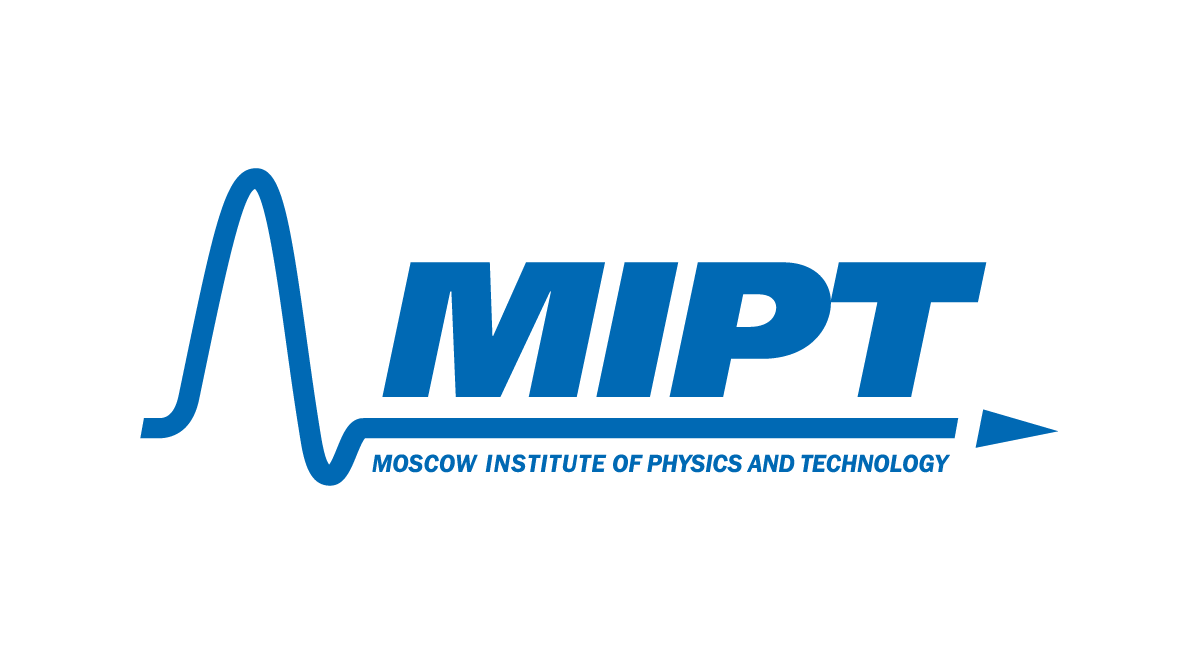</center>
<center>14.11.2023</center>


## Plan

1. StyleGAN
    
    - Finishing the discusion and assessing


2. Energy-Based Models (EBMs)

    - Stochastic Differential Equations and Langevin dynamics
    
    - Maximum Likelihood learning of EBMs
    
    - Practice on 2D data

#### Stochastic Differential Equation (SDE)

$$
\begin{cases}
d \mathbf{z}(t) = f(\mathbf{z}(t), t) d t + g(t) d \mathbf{W} \\
\mathbf{z}(0) \sim p_{z_0}
\end{cases}
$$

$d \mathbf{W}$ is a "differential" of Wiener process

**Euler-Maruyama** simulation:

1. Sample $\mathbf{z}_{0} \sim p_{z_0}$

2. Fix $\tau > 0$ and for $k \in {0, 1, \dots K}$ do: 

$$\mathbf{z}_{(k + 1) \tau} = \mathbf{z}_{k \tau} + f(\mathbf{z}_{k \tau}, k \tau) \tau + g(k \tau) \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

<center>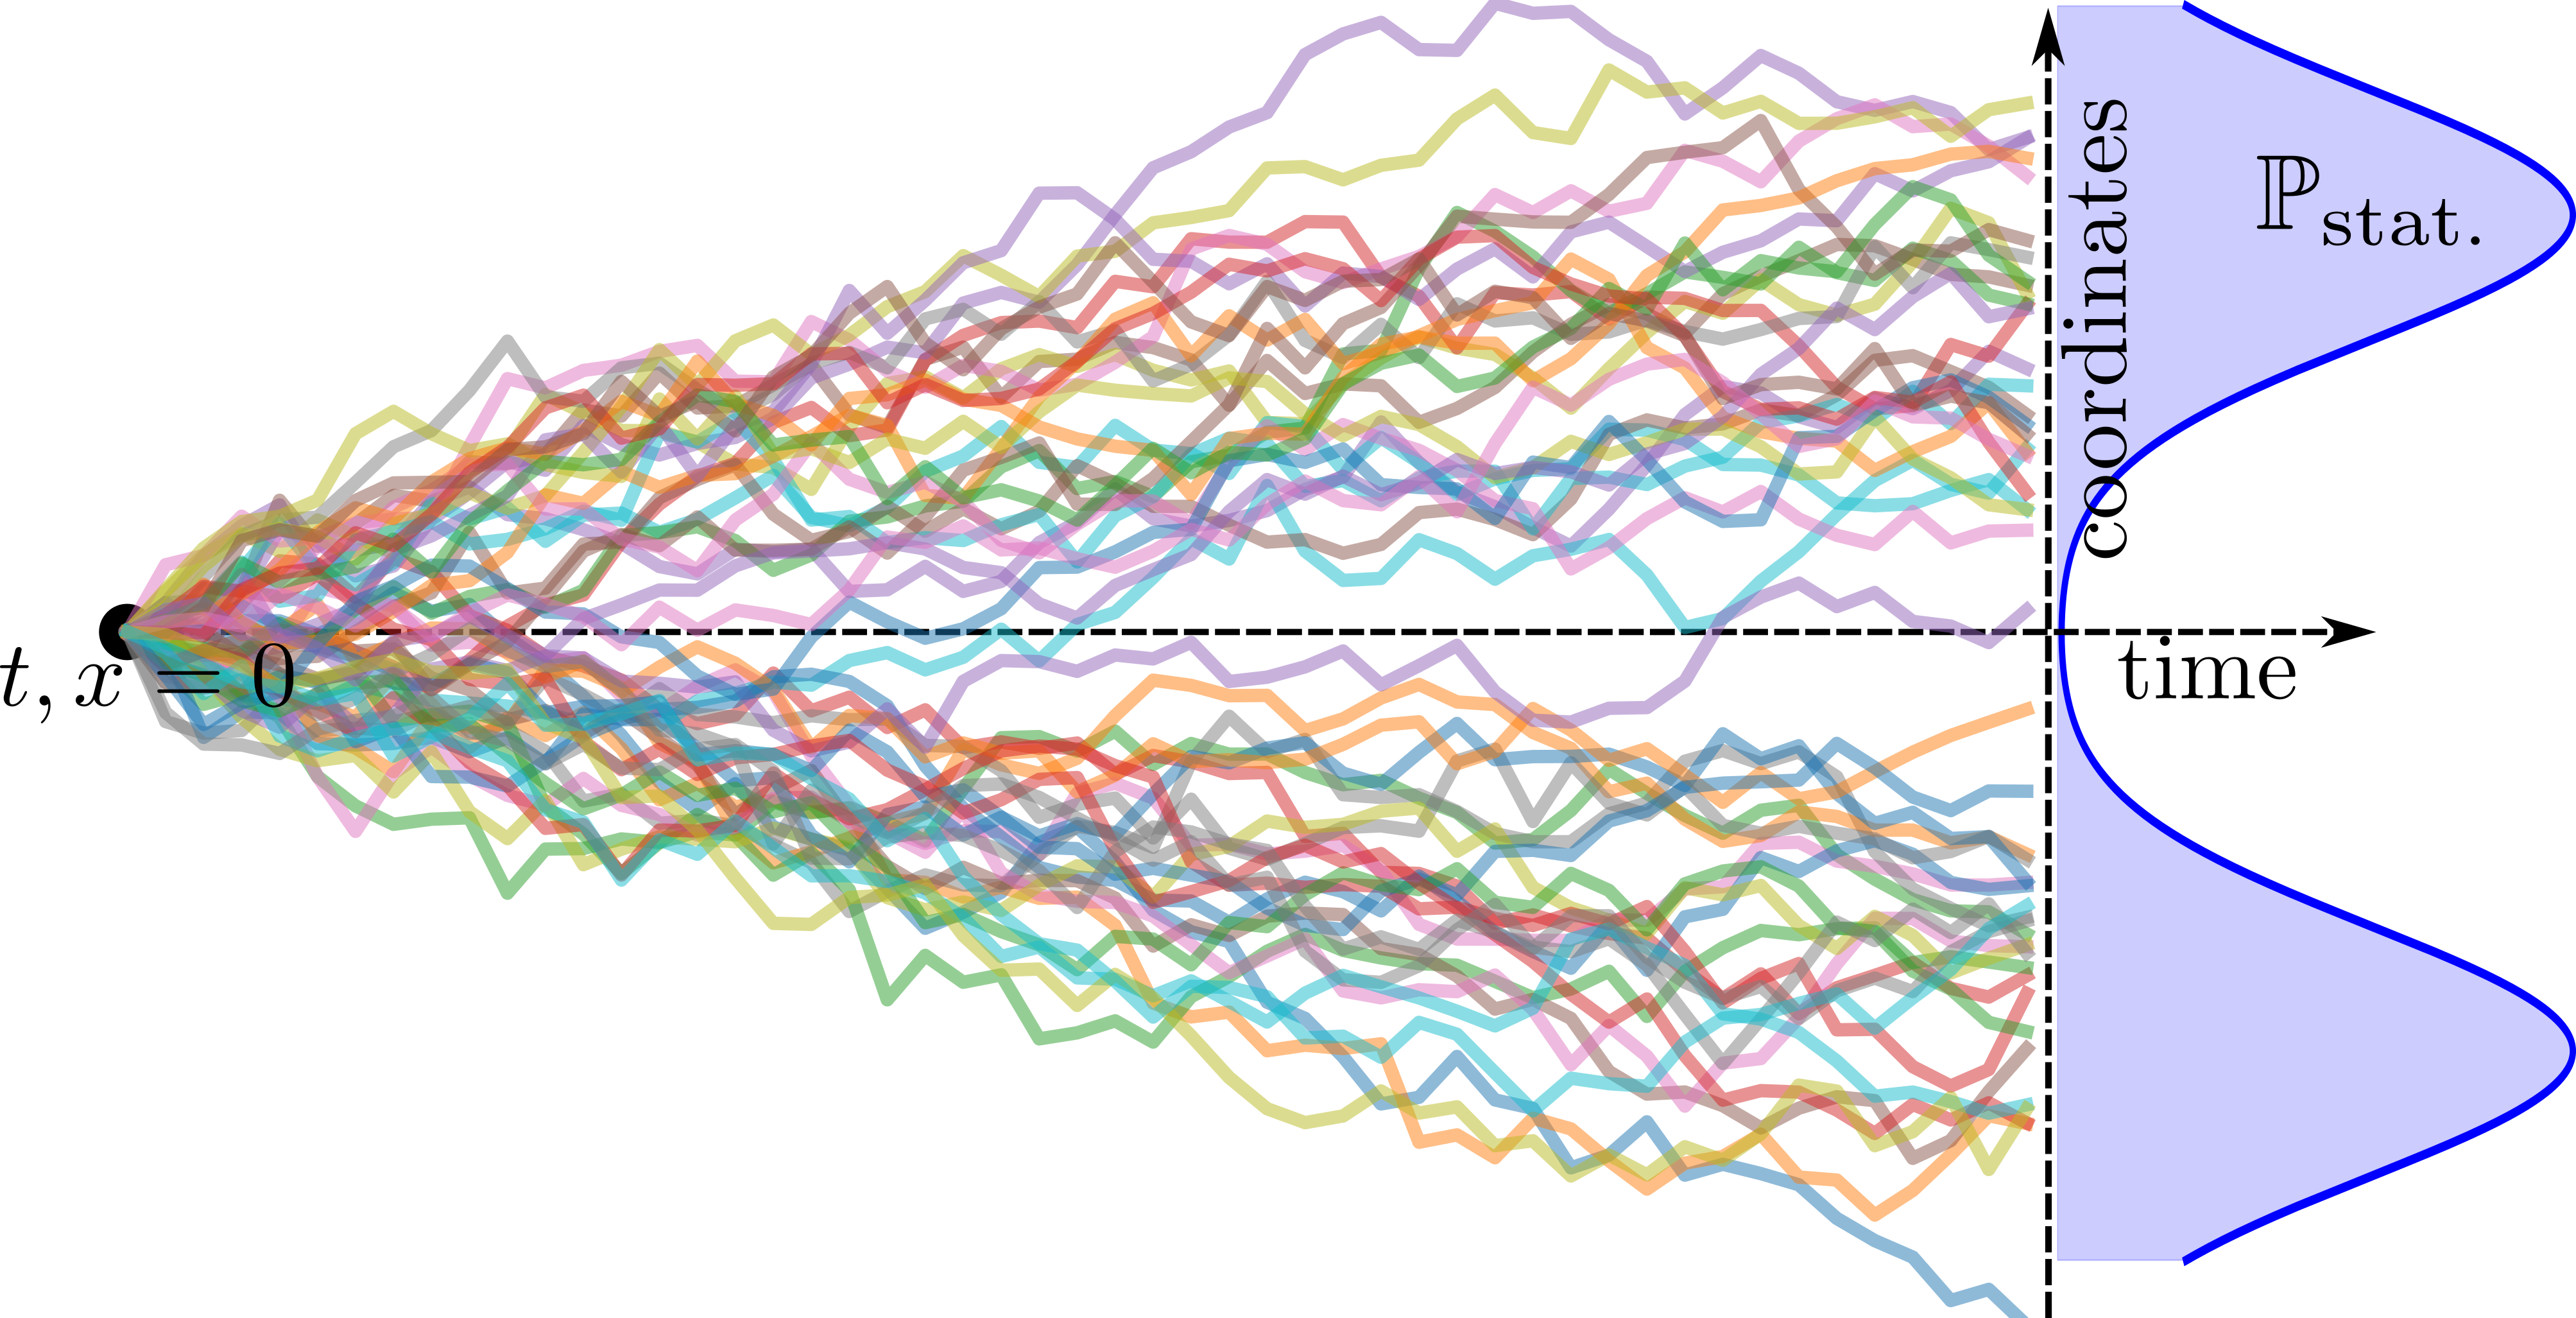</center>

# Energy-Based Models

* Subdomain of **score-based** models (see [Song et. al., How](https://arxiv.org/pdf/2101.03288.pdf))

### Problem setup. Target distribution.

In [7]:
def train_test_split(data):
    count = data.shape[0]
    split = int(0.8 * count)
    train_data, test_data = data[:split], data[split:]
    return train_data, test_data

def create_two_gaussians(noise):
    mix = TD.Categorical(torch.tensor([0.5, 0.5]).to(DEVICE))
    mv_normals = TD.MultivariateNormal(
        torch.tensor([[1., 1.], [-1., -1.]]).to(DEVICE),
        noise * torch.eye(2).unsqueeze(0).repeat_interleave(2, 0).to(DEVICE))
    return TD.MixtureSameFamily(mix, mv_normals)

TwoGaussMixture = create_two_gaussians(0.1)

Samples from target distribution

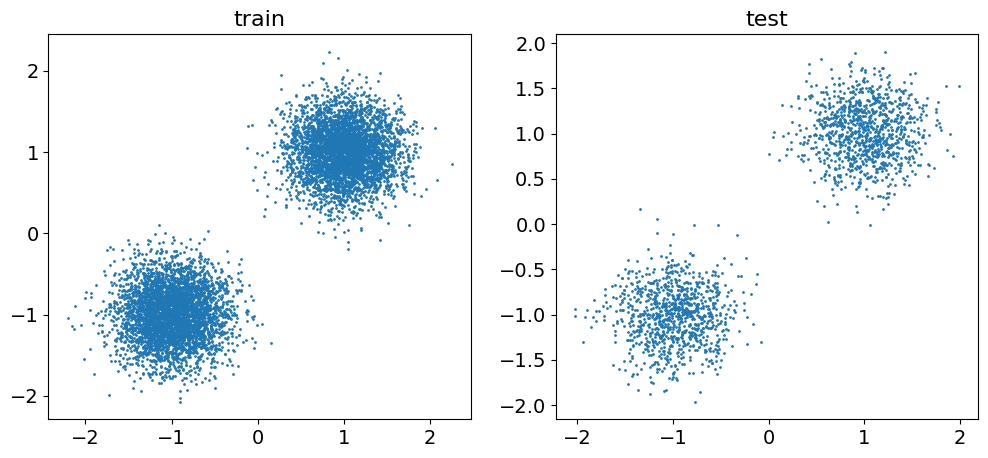

In [8]:
COUNT = 10000

train_data, test_data= train_test_split(TwoGaussMixture.sample((COUNT,)))
visualize_2d_data(train_data.cpu().numpy(), test_data.cpu().numpy())

### Energy function of a distribution

Let $p^*(\mathbf{x})$ is an absolutely continuous distribution, $\mathbf{x} \in \mathbb{R}^D$ 

**Energy function** $E_{p^*}: \mathbb{R}^D \rightarrow \mathbb{R}$ of this distribution is defined as:

$$
p^*(x) = \frac{1}{Z} \exp \left( - E_{p^*}(\mathbf{x}) \right).
$$

* $Z = \int\limits_{\mathbb{R}^D} \exp \left( - E_{p^*}(\mathbf{x}) \right) d \mathbf{x}$ is the *partition function*

* $E_{p^*}(\mathbf{x})$ is (up to an additive constant) **negative log likelihood** of $p^*(\mathbf{x})$

#### Energy function visualization

In [10]:
from seminar10_utils import visualize_2d_torch_scalar_func

In [11]:
def distribution2energy(distrib):
    def energy(x):
        return - distrib.log_prob(x)
    return energy

In [12]:
TwoGaussMixture_Energy = distribution2energy(TwoGaussMixture)

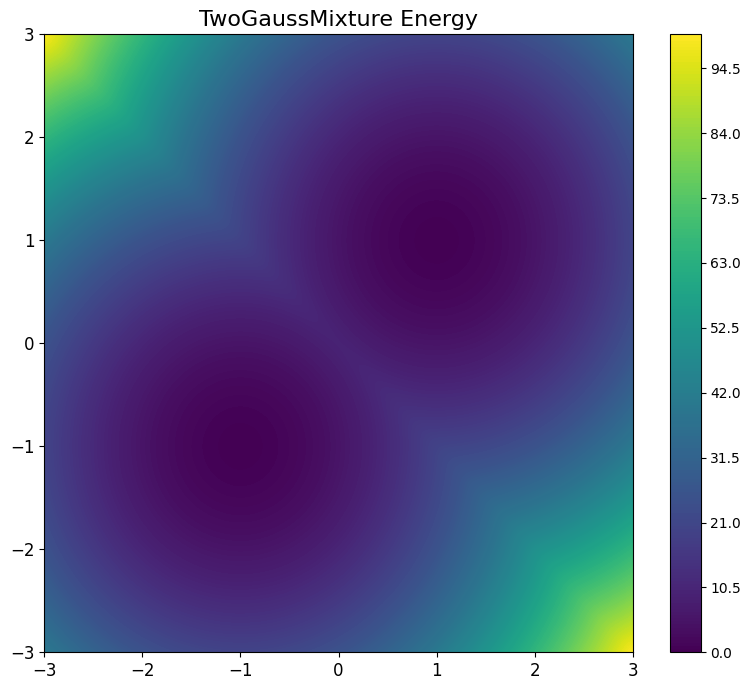

In [13]:
visualize_2d_torch_scalar_func(TwoGaussMixture_Energy, 'TwoGaussMixture Energy', device=DEVICE, val=3., figsize=(8, 7))

### Langevin Dynamics

The **Langevin dynamics** for distribution $p^*(\cdot)$ is given by the following SDE:

$$
\begin{cases}
d \mathbf{x}(t) = - \frac{1}{2}\nabla_{\mathbf{x}} E_{p^*}(\mathbf{x}(t)) d t + d \mathbf{W} \\
\mathbf{x}(0) \sim p_{x_0}
\end{cases}
$$

* $p^*(\cdot)$ is the **stationary** distribution of the process, i.e.: 

$$
p_{x}(\cdot, t) = p^*(\cdot) \Rightarrow p_{x}(\cdot, T) = p^*(\cdot) \text{ for } T \geq t
$$

* One expect the convergence $p_{x}(\cdot, t) \rightarrow p^*$ as $t \rightarrow \infty$ (given $p_{x_0}$ to be some prior distribution)
* Can be used for **Bayesian inference** (one of the MCMC approaches).
* Convergence analysis is **hard**.

* **Score** function of the distribution $p^*(\cdot)$:

$$s(\mathbf{x}) = - \nabla_{\mathbf{x}} E_{p^*}( \mathbf{x} )$$

####  Score function visualization

In [14]:
from seminar10_utils import make_numpy

def plot_score_function(
    score_function, 
    data, 
    title, 
    plot_scatter=True, 
    xlim=(-2., 2.), 
    ylim=(-2., 2.), 
    npts=40, 
    ax=None, 
    figsize=(12, 12),
    scatter_label='GT labels',
    quiver_label = None,
    quiver_color='black'
):
    xx = np.stack(
        np.meshgrid(
            np.linspace(xlim[0], xlim[1], npts), 
            np.linspace(ylim[0], ylim[1], npts)), axis=-1).reshape(-1, 2)
    scores = score_function(torch.tensor(xx).float().to(DEVICE)).detach().cpu().numpy()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    # Perform the plots
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    if (plot_scatter):
        np_data = make_numpy(data)
        ax.scatter(
            np_data[:, 0], np_data[:, 1], alpha=0.3, 
            color='red', edgecolor='white', s=40, label=scatter_label)
    ax.quiver(*xx.T, *scores_log1p.T, width=0.002, color=quiver_color, label=quiver_label)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(title, fontsize=16)
    return ax

In [41]:
from seminar10_utils import batch_jacobian

def distribution2score(distribution):
    def score_function(x):
        x.requires_grad_(True) # (bs, 2)
        log_prob = distribution.log_prob(x).reshape(x.size(0), 1)  # (bs, 1)
        s_raw = batch_jacobian(
            x, log_prob, create_graph=False, retain_graph=False) # (bs, 1, 2)
        return s_raw.reshape(x.size(0), -1).detach()
    return score_function

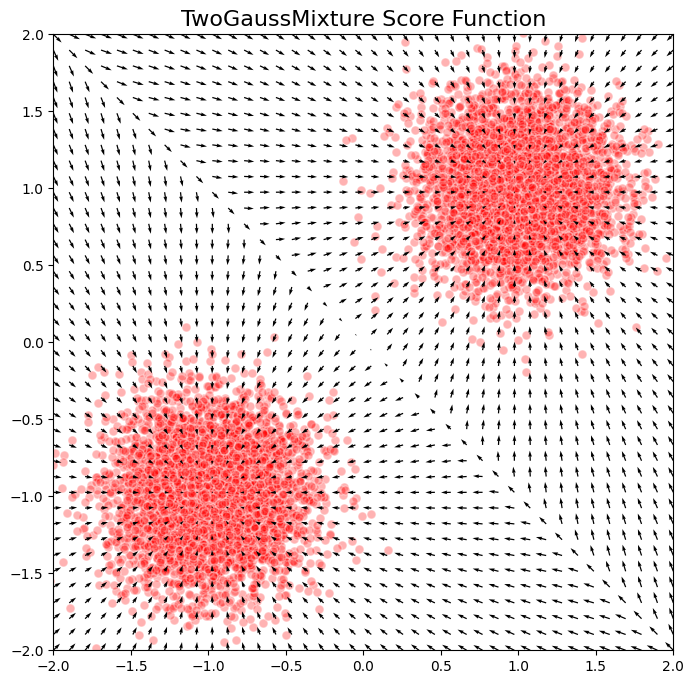

In [42]:
plot_score_function( distribution2score(TwoGaussMixture), train_data, 'TwoGaussMixture Score Function', figsize=(8, 8))
plt.show()

### Langevin dynamics simulation

**Euler-Maruyama** simulation of Langevin dynamics:

1. Sample $\mathbf{x}_{0} \sim p_{x_0}$

2. Fix $\tau > 0$ and for $k \in {0, 1, \dots K}$ do: 

$$\mathbf{x}_{(k + 1) \tau} = \mathbf{x}_{k \tau} - \tau \frac{1}{2} \nabla_{\mathbf{x}} E_{p^*}(\mathbf{x}_{k \tau}) + \Delta \mathbf{W}_k\, ,\\
\text{where } \Delta \mathbf{W}_k \sim \mathcal{N}(0, \tau I)$$

Properties:

* Approximates Langevin dynamics given $\tau > 0$ small enough. It is worth to anneal $\tau$ during simulation.

* Stochastic analogue of gradient ascent algorithm

#### Langevin dynamics visuzalization

In [18]:
def draw_dynamics(dynamics, ax, s=50, linewidth=2):
    np_dynamics = make_numpy(dynamics)
    ax.scatter(np_dynamics[:, 0], np_dynamics[:, 1], color='green', edgecolor='white', s=s, label='langevin dynamics')
    # draw arrows for each mcmc step
    deltas = (np_dynamics[1:] - np_dynamics[:-1])
    deltas = deltas - deltas / np.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        ax.arrow(
            np_dynamics[i,0], np_dynamics[i,1], 
            arrow[0], arrow[1], 
            width=1e-4, head_width=2e-2, color="green", linewidth=linewidth)

In [19]:
def sample_langevin(score_function, x, n_steps=100, eps=1e-2, decay=1.0, store_history=False):
    if store_history:
        x_sequence = [x.detach().cpu()]

    for s in range(n_steps):

        ## Langevin dynamics
        z_t = torch.randn(x.size()).to(x)
        x = x + (eps / 2) * score_function(x) + (np.sqrt(eps) * z_t)
        eps *= decay

        if store_history:
            x_sequence.append(x.detach().cpu())
    if store_history:
        return x, torch.cat(x_sequence)
    return x

Euler-Maruyama simulation of Langevin dynamics example

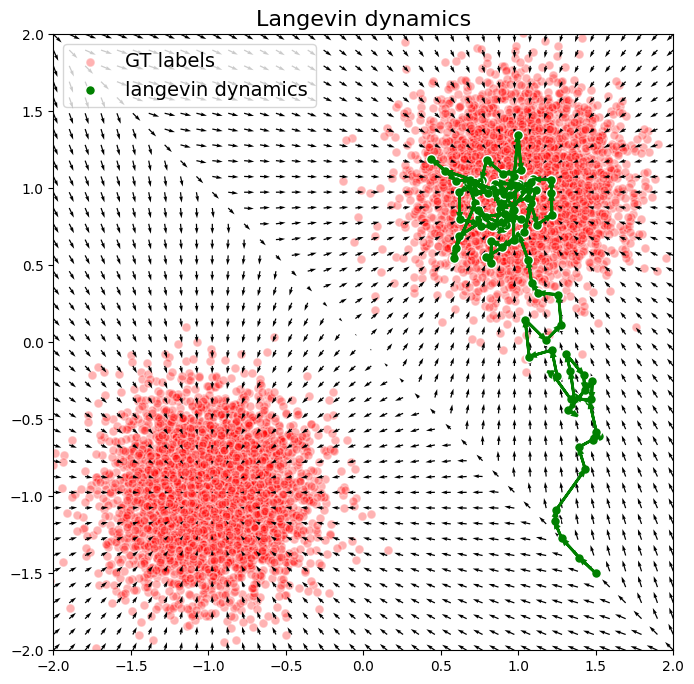

In [20]:
ax = plot_score_function(distribution2score(TwoGaussMixture), train_data, 'Langevin dynamics', figsize=(8, 8))
x = torch.Tensor([[1.5, -1.5]]).to(DEVICE)
final_x, samples = sample_langevin(distribution2score(TwoGaussMixture), x, store_history=True)
draw_dynamics(samples, ax)
plt.legend(fontsize=14)
plt.show()

#### Additional Langevin dynamics visualization

Taken from [Yang Song's blog](https://yang-song.net/blog/2021/score/)

<center><img src="https://yang-song.net/assets/img/score/langevin.gif?raw=true" width=600 /></center>

### Maximum Likelihood learning of EBMs

Let us parameterize $E_{p^*}$ as a neural network $E_{\theta}$ to be learned:

* At optimal parameter $\theta^*$: $E_{\theta^*} \approx E_{p^*}$

**Question**: Let us consider (a) 2D data (b) image data. What does Energy Neural Network $E_{\theta}$ take as input and output? Dimensionality?

Define $p_{\theta}(\mathbf{x}) = \frac{1}{Z(\theta)} \exp \left( - E_\theta(\mathbf{x}) \right)$ , $Z(\theta) = \int_{\mathbb{R}^D} \exp \left( - E_\theta(\mathbf{x}) \right) d \mathbf{x}$

**Maximum Likelihood learning**:

$$
\mathcal{L}(\theta) = - \mathbb{E}_{x \sim p^*} \log p_{\theta}(x) \rightarrow \min_{\theta}
$$

**Statement**:

$$
\mathcal{L}(\theta) = \log Z(\theta) + \mathbb{E}_{x \sim p^*} E_{\theta}(x) \\
\frac{d}{d \theta} \mathcal{L}(\theta) = \mathbb{E}_{x \sim p^*} \left( \frac{\partial}{\partial \theta}E_{\theta}(x)\right) - \mathbb{E}_{\color{red}{ x \sim p_{\theta}}} \left( \frac{\partial}{\partial \theta}E_{\theta}(\color{red}{x})\right)
$$

**Gradient descent update**:

$$
\theta_{i + 1} = \theta_{i} - \lambda \frac{d}{d \theta} \mathcal{L}(\theta_i) = \theta_{i} - \lambda \frac{d}{d \theta} \bigg( \color{blue}{\mathbb{E}_{x \sim p^*} E_{\theta}(x) -  \mathbb{E}_{\color{red}{ x \sim p_{\theta}}} E_{\theta}(\color{black}{\text{stop_grad}}[\color{red}{x}])} \bigg)
$$

We can treat the expression in $\color{blue}{\text{blue}}$ as a "proxy" loss:

$$
G(\theta) = \color{blue}{\mathbb{E}_{x \sim p^*} E_{\theta}(x) -  \mathbb{E}_{\color{red}{ x \sim p_{\theta}}} E_{\theta}(\color{black}{\text{stop_grad}}[\color{red}{x}])}
$$

Let $\{x^+_i\}_{i = 1}^{N} \sim p^*$ ; $\{x^-_i\}_{i = 1}^{N} \sim p_{\theta}$. Batch estimate $\hat{G}(\theta)$:

$$
\hat{G}(\theta) = \frac{1}{N} \sum\limits_{i = 1}^{N} E_{\theta}(x_i^+) - \frac{1}{N} \sum\limits_{i = 1}^{N} E_{\theta}(\text{stop_grad}(x_i^-))
$$

**Question**: How to obtain samples from $p_{\theta}$?

### EBMs practice in 2D

**Model**

In [43]:
from seminar10_utils import FullyConnectedMLP

class EBM2D(FullyConnectedMLP):

    def log_prob(self, x):
        return -self(x)
    
    def score(self, x):
        with torch.enable_grad():
            x.requires_grad_(True) # (bs, 2)
            energy = self.forward(x) # (bs, 1)
            score = - batch_jacobian(x, energy, create_graph=False, retain_graph=False) # (bs, 1, 2)
            score = score.squeeze(1) # (bs, 2)
        return score.detach()

    def sample(self, n_samples, n_steps):
        x_k = self.basic_noise.sample((n_samples, 2)) # (n_spl, 2)
        for k in range(n_steps):
            score = self.score(x_k)
            x_k.data += 0.5 * score + np.sqrt(self.config.ENERGY_SAMPLING_EPS) * torch.randn_like(x_k)
        return x_k.detach()

    def __init__(self, config=None):
        self.basic_noise = TD.Normal(
            torch.tensor([0.0]).to(DEVICE), 
            torch.tensor([1.0]).to(DEVICE) * config.NOISE_SIGMA
        )
        self.config = config
        super().__init__(2, config.HIDDENS, 1)

    def loss(self, x_plus):
        x_minus = self.sample(x.size(0), self.config.ENERGY_SAMPLING_ITERATIONS)
        L = self.forward(x_plus).mean() - self.forward(x_minus).mean()
        return {'loss': L }

**Training**

In [44]:
class Config:
    pass

config = Config()
config.ENERGY_SAMPLING_ITERATIONS = 100
config.HIDDENS = [512, 512]
config.ENERGY_SAMPLING_EPS = 0.1
config.NOISE_SIGMA = 1.
config.BATCH_SIZE = 256
config.EPOCHS = 30 # 30

In [45]:
model = EBM2D(config)

In [46]:
train_loader = DataLoader(train_data, shuffle=True, batch_size = config.BATCH_SIZE)

test_loader = DataLoader(test_data, shuffle=False, batch_size = config.BATCH_SIZE)

In [47]:
train_losses, test_losses = train_model(
    model,
    train_loader, 
    test_loader,
    config.EPOCHS,
    lr=1e-4,
    use_tqdm=True,
    use_cuda=True,
    loss_key = 'loss'
)

  0%|          | 0/30 [00:00<?, ?it/s]

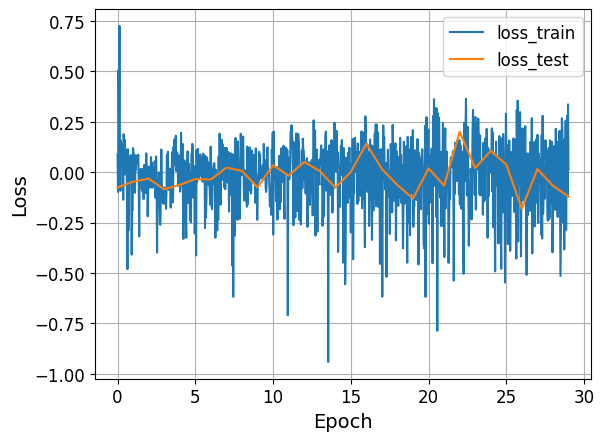

In [48]:
plot_training_curves(train_losses, test_losses)

In [49]:
sample = model.sample(5000, 500).detach().cpu().numpy()

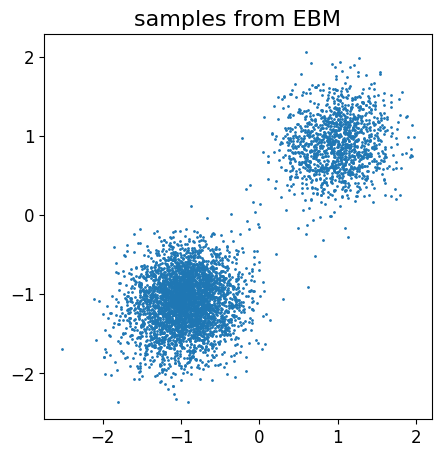

In [50]:
visualize_2d_samples(sample, 'samples from EBM')

<Axes: title={'center': 'TwoGaussMixture Learned Score Function'}>

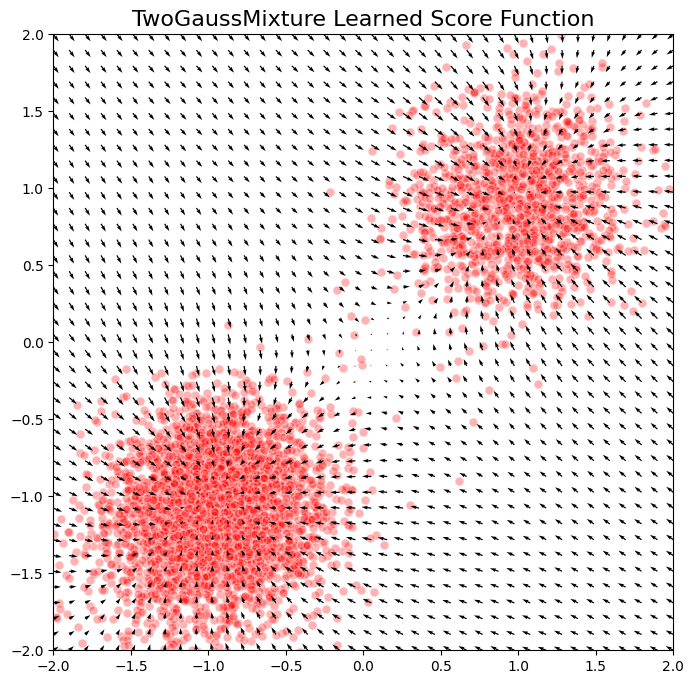

In [52]:
plot_score_function( distribution2score(model), sample, 'TwoGaussMixture Learned Score Function', figsize=(8, 8))

**Further reading**:

* [Du & Mordatch, IGEBM](https://papers.nips.cc/paper_files/paper/2019/hash/378a063b8fdb1db941e34f4bde584c7d-Abstract.html)

* [Nijkamp et. al., Anatomy](https://arxiv.org/abs/1903.12370)